## Tensorflow training 1D potential example


Since this is a bit more advanced than the sklearn we recommend you start the other one first

In [3]:
"""First we import our dataset examples"""
from MLTSA_datasets.OneD_pot.OneD_pot_data import potentials
from MLTSA_datasets.OneD_pot.OneD_pot_data import dataset
import matplotlib.pyplot as plt
import numpy as np

#This sets the potentials, don't re-run
total_n_pots = 25
n_DW = 5
relevant_DW_n = 2
#After defining the desired parameters we define the potentials accordingly
pots = potentials(total_n_pots, n_DW, relevant_DW_n)
# This creates the first dataset of data.
# It creates the mixing coefficients don't re-run
n_features = 180
degree_of_mixing = 2
#We specified the number of features wanted and how much they will mix
oneD_dataset = dataset(pots, n_features, degree_of_mixing)


Defining Potentials: 100%|###########################################################| 25/25 [00:00<00:00, 1783.84it/s]


This has set up our dataset for further use, since TensorFlow is more scalable and compatible with GPU calculations, we will do a more extensive search on this example. 

Let's generate the actual linear mixed data we will use for training.   


In [4]:
#Generate the trajectories
n_simulations = 100
n_steps = 500
data, ans = oneD_dataset.generate_linear(n_simulations, n_steps)
data_val, ans_val = oneD_dataset.generate_linear(int(n_simulations/2), n_steps)

#Prepare it for training
time_frame = [30, 60] #Same time frame as the sklearn one
X, Y = oneD_dataset.PrepareData(data, ans, time_frame, mode="Normal")
X_val, Y_val = oneD_dataset.PrepareData(data_val, ans_val, time_frame, mode="Normal")

Generating dataset


Running Simulations: 100%|###########################################################| 100/100 [00:23<00:00,  4.18it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|#######################################################| 100/100 [00:00<?, ?it/s]


Generating dataset


Running Simulations: 100%|#############################################################| 50/50 [00:10<00:00,  4.70it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|#########################################################| 50/50 [00:00<?, ?it/s]


Now this data is generated as (X/Features, Y/labels) but those labels are strings which TensorFlow cannot handle as easy. Let's encode them for our Neural Network. 

In [6]:
#We will convert IN and OUT to numerical labels
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(len(Y), 1)).toarray()
Y_val = encoder.fit_transform(Y_val.reshape(len(Y_val),1)).toarray()
print(Y)
print(Y_val)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]



Now that we have got the X and Y ready to fit to, we will train the model, in this example we want to train a Multi-Layer Perceptron just like the one in Sklearn, but we will use TensorFlow instead. For this we will have to build the models first using the build_MLP function under the MLTSA_tensorflow integrated package. This will print a summay of our model to check that the dimensions and size for each layer are correct. 


In [85]:
#We will start with the basic Multi-Layer Perceptron
from MLTSA_tensorflow import TF_2_MLP

MLP = TF_2_MLP.build_MLP(n_steps, n_features, n_labels=2).model

Building Simple MLP
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               18100     
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 2)                 202       
                                                                 
Total params: 28,402
Trainable params: 28,402
Non-trainable params: 0
_________________________________________________________________
None


Now let's put to train the MLP, in this case we can make use of the fit() function of our model and call the data (X,Y) directly without any other preparation. We will use X_val and Y_val later for further validation. 

In [86]:
from tensorflow.keras.callbacks import EarlyStopping

#In this training we implement the same methodology as in the paper by using early stopping and a maximum of 500 iterations. 
train_log = MLP.fit(X, Y, epochs=500, batch_size=n_steps, verbose=1, validation_split=0.2,
        callbacks=[EarlyStopping(monitor='accuracy', min_delta=1e-8, restore_best_weights=True, patience=100)])

#We use now the X_val and Y_val to evaluate the quality of the training. 
val_acc = MLP.evaluate(X_val, Y_val, verbose=1)

Epoch 1/500
5/5 [==============================] - 0s 36ms/step - loss: 0.7589 - accuracy: 0.4921 - val_loss: 0.8553 - val_accuracy: 0.3500
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 0.7022 - accuracy: 0.5592 - val_loss: 0.7021 - val_accuracy: 0.3500
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6946 - accuracy: 0.5275 - val_loss: 0.7372 - val_accuracy: 0.3500
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.5642 - val_loss: 0.7848 - val_accuracy: 0.3500
Epoch 5/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6895 - accuracy: 0.5704 - val_loss: 0.7306 - val_accuracy: 0.3500
Epoch 6/500
5/5 [==============================] - 0s 12ms/step - loss: 0.6879 - accuracy: 0.5512 - val_loss: 0.7440 - val_accuracy: 0.3500
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6803 - accuracy: 0.5796 - val_loss: 0.7592 - val_accuracy: 0.3500
Epoch 8/500
5/5 [===

5/5 [==============================] - 0s 11ms/step - loss: 0.6026 - accuracy: 0.6850 - val_loss: 0.6442 - val_accuracy: 0.6717
Epoch 60/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6058 - accuracy: 0.6900 - val_loss: 0.6841 - val_accuracy: 0.4050
Epoch 61/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6148 - accuracy: 0.6229 - val_loss: 0.8068 - val_accuracy: 0.3500
Epoch 62/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6113 - accuracy: 0.6729 - val_loss: 0.8108 - val_accuracy: 0.3500
Epoch 63/500
5/5 [==============================] - 0s 11ms/step - loss: 0.5998 - accuracy: 0.6717 - val_loss: 0.8004 - val_accuracy: 0.3500
Epoch 64/500
5/5 [==============================] - 0s 11ms/step - loss: 0.5986 - accuracy: 0.6888 - val_loss: 0.7716 - val_accuracy: 0.3533
Epoch 65/500
5/5 [==============================] - 0s 11ms/step - loss: 0.5841 - accuracy: 0.7242 - val_loss: 0.6424 - val_accuracy: 0.6267
Epoch 66/500
5/5 [========

5/5 [==============================] - 0s 11ms/step - loss: 0.3629 - accuracy: 0.8550 - val_loss: 0.7332 - val_accuracy: 0.5183
Epoch 118/500
5/5 [==============================] - 0s 10ms/step - loss: 0.3632 - accuracy: 0.8433 - val_loss: 0.4246 - val_accuracy: 0.8083
Epoch 119/500
5/5 [==============================] - 0s 10ms/step - loss: 0.3466 - accuracy: 0.8658 - val_loss: 0.4574 - val_accuracy: 0.7783
Epoch 120/500
5/5 [==============================] - 0s 10ms/step - loss: 0.3209 - accuracy: 0.8933 - val_loss: 0.4348 - val_accuracy: 0.8117
Epoch 121/500
5/5 [==============================] - 0s 10ms/step - loss: 0.3437 - accuracy: 0.8633 - val_loss: 0.4386 - val_accuracy: 0.8033
Epoch 122/500
5/5 [==============================] - 0s 10ms/step - loss: 0.4216 - accuracy: 0.7979 - val_loss: 0.5593 - val_accuracy: 0.6650
Epoch 123/500
5/5 [==============================] - 0s 10ms/step - loss: 0.3302 - accuracy: 0.8696 - val_loss: 0.3989 - val_accuracy: 0.8750
Epoch 124/500
5/5 [=

5/5 [==============================] - 0s 11ms/step - loss: 0.4223 - accuracy: 0.7825 - val_loss: 0.4756 - val_accuracy: 0.7567
Epoch 175/500
5/5 [==============================] - 0s 11ms/step - loss: 0.3319 - accuracy: 0.8462 - val_loss: 0.4143 - val_accuracy: 0.8033
Epoch 176/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2667 - accuracy: 0.8925 - val_loss: 0.4681 - val_accuracy: 0.7583
Epoch 177/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2540 - accuracy: 0.9008 - val_loss: 0.3690 - val_accuracy: 0.8150
Epoch 178/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2617 - accuracy: 0.8975 - val_loss: 0.4441 - val_accuracy: 0.7750
Epoch 179/500
5/5 [==============================] - 0s 12ms/step - loss: 0.2382 - accuracy: 0.9117 - val_loss: 0.4020 - val_accuracy: 0.8167
Epoch 180/500
5/5 [==============================] - 0s 12ms/step - loss: 0.2428 - accuracy: 0.9087 - val_loss: 0.5112 - val_accuracy: 0.7433
Epoch 181/500
5/5 [=

Epoch 232/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2435 - accuracy: 0.8954 - val_loss: 0.3566 - val_accuracy: 0.8433
Epoch 233/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2335 - accuracy: 0.9004 - val_loss: 0.4826 - val_accuracy: 0.7517
Epoch 234/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2957 - accuracy: 0.8600 - val_loss: 0.5236 - val_accuracy: 0.7617
Epoch 235/500
5/5 [==============================] - 0s 11ms/step - loss: 0.4152 - accuracy: 0.7967 - val_loss: 0.5771 - val_accuracy: 0.6917
Epoch 236/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2955 - accuracy: 0.8733 - val_loss: 0.3675 - val_accuracy: 0.8200
Epoch 237/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2861 - accuracy: 0.8708 - val_loss: 0.4944 - val_accuracy: 0.7333
Epoch 238/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2634 - accuracy: 0.8929 - val_loss: 0.3713 - val_accuracy: 0.8133
Epoch 

5/5 [==============================] - 0s 10ms/step - loss: 0.2147 - accuracy: 0.9158 - val_loss: 0.3550 - val_accuracy: 0.8467
Epoch 290/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2379 - accuracy: 0.8950 - val_loss: 0.4786 - val_accuracy: 0.7617
Epoch 291/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2482 - accuracy: 0.8867 - val_loss: 0.5312 - val_accuracy: 0.7483
Epoch 292/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2148 - accuracy: 0.9171 - val_loss: 0.3715 - val_accuracy: 0.8033
Epoch 293/500
5/5 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.94 - 0s 11ms/step - loss: 0.1775 - accuracy: 0.9333 - val_loss: 0.3727 - val_accuracy: 0.8133
Epoch 294/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1797 - accuracy: 0.9325 - val_loss: 0.4060 - val_accuracy: 0.8167
Epoch 295/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2032 - accuracy: 0.9125 - val_loss: 0.5725 -

5/5 [==============================] - 0s 10ms/step - loss: 0.2681 - accuracy: 0.8750 - val_loss: 0.3674 - val_accuracy: 0.8050
Epoch 347/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2460 - accuracy: 0.8942 - val_loss: 0.3718 - val_accuracy: 0.8200
Epoch 348/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2167 - accuracy: 0.9046 - val_loss: 0.4859 - val_accuracy: 0.7750
Epoch 349/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2121 - accuracy: 0.9083 - val_loss: 0.3519 - val_accuracy: 0.8300
Epoch 350/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2015 - accuracy: 0.9200 - val_loss: 0.5105 - val_accuracy: 0.7633
Epoch 351/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1901 - accuracy: 0.9242 - val_loss: 0.3576 - val_accuracy: 0.8517
Epoch 352/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2190 - accuracy: 0.8975 - val_loss: 0.3874 - val_accuracy: 0.8050
Epoch 353/500
5/5 [=

Epoch 404/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1721 - accuracy: 0.9296 - val_loss: 0.4582 - val_accuracy: 0.7983
Epoch 405/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1694 - accuracy: 0.9362 - val_loss: 0.3633 - val_accuracy: 0.8133
Epoch 406/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1647 - accuracy: 0.9350 - val_loss: 0.3804 - val_accuracy: 0.8200
Epoch 407/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1688 - accuracy: 0.9312 - val_loss: 0.3722 - val_accuracy: 0.8200
Epoch 408/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1552 - accuracy: 0.9421 - val_loss: 0.3827 - val_accuracy: 0.8067
Epoch 409/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1625 - accuracy: 0.9321 - val_loss: 0.4697 - val_accuracy: 0.7917
Epoch 410/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1692 - accuracy: 0.9279 - val_loss: 0.3560 - val_accuracy: 0.8283
Epoch 

Epoch 462/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2561 - accuracy: 0.8925 - val_loss: 0.5622 - val_accuracy: 0.7233
Epoch 463/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2589 - accuracy: 0.8921 - val_loss: 0.3540 - val_accuracy: 0.8100
Epoch 464/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2451 - accuracy: 0.8904 - val_loss: 0.4878 - val_accuracy: 0.7633
Epoch 465/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1970 - accuracy: 0.9183 - val_loss: 0.3724 - val_accuracy: 0.8150
Epoch 466/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1869 - accuracy: 0.9225 - val_loss: 0.4047 - val_accuracy: 0.8033
Epoch 467/500
5/5 [==============================] - 0s 10ms/step - loss: 0.1815 - accuracy: 0.9267 - val_loss: 0.4997 - val_accuracy: 0.7683
Epoch 468/500
5/5 [==============================] - 0s 11ms/step - loss: 0.1923 - accuracy: 0.9250 - val_loss: 0.3589 - val_accuracy: 0.8233
Epoch 

In [87]:
print("We achieved", val_acc[1]*100, "% accuracy on Validation and ", max(train_log.history["accuracy"])*100, "% accuracy on Training")

We achieved 82.40000009536743 % accuracy on Validation and  94.20833587646484 % accuracy on Training



The previous training has generated a record of the training, test and validation accuracy as well as the evolution of the loss throughout the epochs. 

These can be plotted to see how the model is learning the outcome. To do this we need to callback the history which is in 


In [88]:
loss  = train_log.history["loss"]
val_loss = train_log.history["val_loss"]
acc_train = train_log.history["accuracy"]
acc_val = train_log.history["val_accuracy"]

Text(0, 0.5, 'loss')

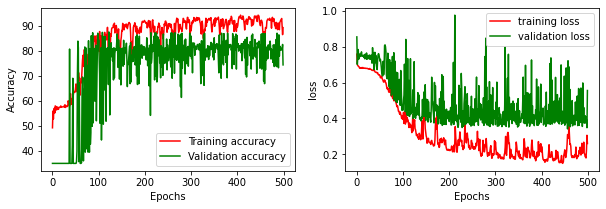

In [89]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(np.array(acc_train)*100, color="r", label="Training accuracy")
ax[0].plot(np.array(acc_val)*100, color="g", label="Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(loss, label="training loss", color="r")
ax[1].plot(val_loss, label="validation loss", color="g")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")


Now we can move onto trying the MLTSA for this ML model. For that we call the MLTSA() method within the tensorflow package.


In [121]:
def MLTSA__(data, ans, model, mode=""):
    from tqdm import tqdm
    
    if mode == "Normal":
        data = data[:, :-1, :]

    # Calculating the global means
    means_per_sim = np.mean(data.T, axis=0)
    gmeans = np.mean(means_per_sim, axis=1)
    temp_sim_data = np.copy(data)

    # Swapping the values and predicting for the FR
    FR = []
    for y, data in tqdm(enumerate(temp_sim_data)):
        mean_sim = []
        for n, mean in enumerate(gmeans):
            tmp_dat = np.copy(data)
            # print(tmp_dat.shape)
            tmp_dat[n, :] = mean
            # print(tmp_dat.T.shape)
            yy = model.predict(tmp_dat.T)
            res = yy == ans[y]
            mean_sim.append(res)
        FR.append(mean_sim)
    print()
    fr_per_sim = np.mean(np.array(FR).T, axis=0)
    fr = np.mean(fr_per_sim, axis=1)
    return fr

In [128]:
#from MLTSA_tensorflow.MLTSA_tf import MLTSA

ans_labels = encoder.fit_transform(np.array(ans).reshape(-1,1)).toarray()

a_drop = MLTSA__(data[:,:,time_frame[0]:time_frame[1]], ans_labels, MLP, mode="tf")

#MLTSA__(data[:10,:,0:10], ans_labels[:10], MLP, mode="tf")

100it [10:24,  6.24s/it]